<a href="https://colab.research.google.com/github/farazjawedd/Explainable-AI/blob/main/Adversarial_AI_FJ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt -O imagenet_classes.txt


--2025-03-06 09:13:35--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0.001s  

2025-03-06 09:13:35 (13.5 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]



In [1]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

from google.colab import files
uploaded = files.upload()

image_path = list(uploaded.keys())[0]
print(f"✅ Uploaded image: {image_path}")

image = Image.open(image_path).convert("RGB")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

input_tensor = transform(image).unsqueeze(0)

Saving golden-retriever-dog-breed-info.jpeg to golden-retriever-dog-breed-info.jpeg
✅ Uploaded image: golden-retriever-dog-breed-info.jpeg


In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

input_tensor = transform(image).unsqueeze(0)

model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
model.eval()

imagenet_classes = models.ResNet34_Weights.IMAGENET1K_V1.meta["categories"]

output = model(input_tensor)
pred_label = imagenet_classes[output.argmax().item()]
print(f"✅ Original Prediction: {pred_label}")


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 177MB/s]


✅ Original Prediction: golden retriever


In [3]:
patch_size = (100, 100)

patch = torch.ones(3, *patch_size, requires_grad=True)
x_offset, y_offset = 62, 62

def apply_patch(image_tensor, patch, x_offset, y_offset):
    patched_image = image_tensor.clone()
    patch = patch.unsqueeze(0)
    patched_image[:, :, y_offset:y_offset+patch_size[1], x_offset:x_offset+patch_size[0]] = patch
    return patched_image

optimizer = torch.optim.Adam([patch], lr=0.05)


Step 0, Loss: -82.34239959716797
Step 100, Loss: -96.97319793701172
Step 200, Loss: -103.38886260986328
Step 300, Loss: -107.23844146728516
Step 400, Loss: -110.26397705078125
Step 500, Loss: -112.42879486083984
Step 600, Loss: -114.1259765625
Step 700, Loss: -115.6868667602539
Step 800, Loss: -116.918701171875
Step 900, Loss: -117.92015838623047


🚀 Adversarial Prediction: paper towel


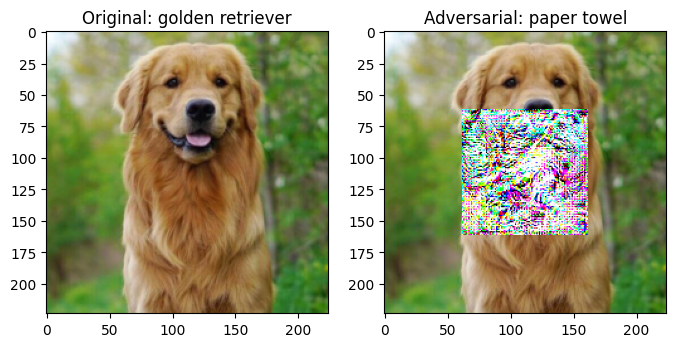

✅ Patch saved as adversarial_patch.png


In [5]:
target_class = 609

for i in range(1000):
    patched_image = apply_patch(input_tensor, patch, x_offset, y_offset)
    output = model(patched_image)

    loss = -F.cross_entropy(output, torch.tensor([target_class], dtype=torch.long))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % 100 == 0:
        print(f"Step {i}, Loss: {loss.item()}")

patched_output = model(apply_patch(input_tensor, patch, x_offset, y_offset))
patched_pred_label = imagenet_classes[patched_output.argmax().item()]
print(f"🚀 Adversarial Prediction: {patched_pred_label}")

plt.figure(figsize=(8,4))

# Original image
plt.subplot(1,2,1)
plt.imshow(input_tensor.squeeze().permute(1,2,0).detach().cpu().numpy())
plt.title(f"Original: {pred_label}")

# Patched image
plt.subplot(1,2,2)
plt.imshow(apply_patch(input_tensor, patch, x_offset, y_offset).squeeze().permute(1,2,0).detach().cpu().numpy())
plt.title(f"Adversarial: {patched_pred_label}")

plt.show()


patch_image = patch.detach().squeeze().permute(1,2,0).cpu().numpy()

patch_image = np.clip(patch_image, 0, 1)

# Save the patch as an image
plt.imsave("adversarial_patch.png", patch_image)
print("✅ Patch saved as adversarial_patch.png")

